# Mean bias

Assessment of model mean bias over the 2000-2019 period.

(Bias corrected data for the period 2000-2019 was produced by training on data from the 1980-1999 period.)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import utils

In [2]:
def calc_mean(da, var):
    """Calculate the mean"""
    
    if var == 'pr':
        mean = da.groupby('time.year').sum(dim="time").mean(dim='year')
    else:
        mean = da.groupby('time.year').mean(dim="time").mean(dim='year')
        
    return mean

In [3]:
def get_data(var, rcm):
    """Get data needed for the evaluation"""

    assert rcm in ['BOM-BARPA-R', 'UQ-DES-CCAM-2105']
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    mean_obs = calc_mean(da_obs, var)
   
    da_gcm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        'GCM',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_raw = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_ecdfm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'ecdfm',
        'task-historical',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    # TODO: Add additional bias correction methods as data becomes available 

    return mean_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm

In [4]:
def plot_mean_bias(ax, mean_obs, da_model, var, cmap, levels, model_name):
    """Plot the mean bias for a particular model"""
    
    mean_model = calc_mean(da_model, var)
    bias = mean_model - mean_obs
        
    units = 'mm/year' if var == 'pr' else da_model.attrs['units']
    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': units},
    )
    ax.set_title(model_name)
    ax.coastlines()

In [5]:
def plot_comparison(var, rcm, cmap, levels):
    """Plot the complete comparison"""

    mean_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm = get_data(var, rcm)

    fig = plt.figure(figsize=[24, 6])
    ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax1, mean_obs, da_gcm, var, cmap, levels, 'CSIRO-ACCESS-ESM1-5',
    )
    ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax2, mean_obs, da_rcm_raw, var, cmap, levels, f'{rcm} (raw)'
    )
    ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax3, mean_obs, da_rcm_ecdfm, var, cmap, levels, f'{rcm} (ecdfm)'
    )
    long_name = da_rcm_raw.attrs['long_name']
    plt.suptitle(f'Bias (model minus obs) in the 2000-2019 annual mean {long_name}')
    plt.show()

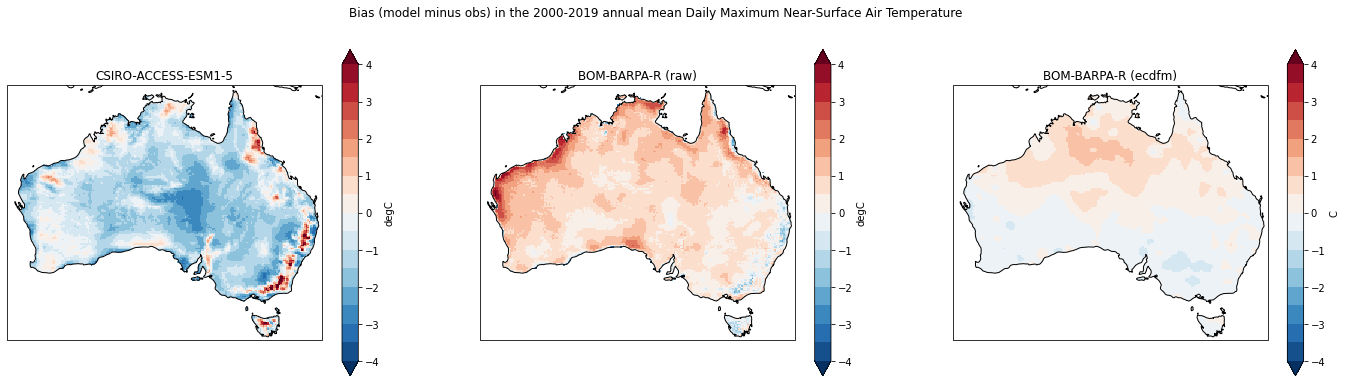

In [16]:
plot_comparison('tasmax', 'BOM-BARPA-R', 'RdBu_r', np.arange(-4, 4.01, 0.5))

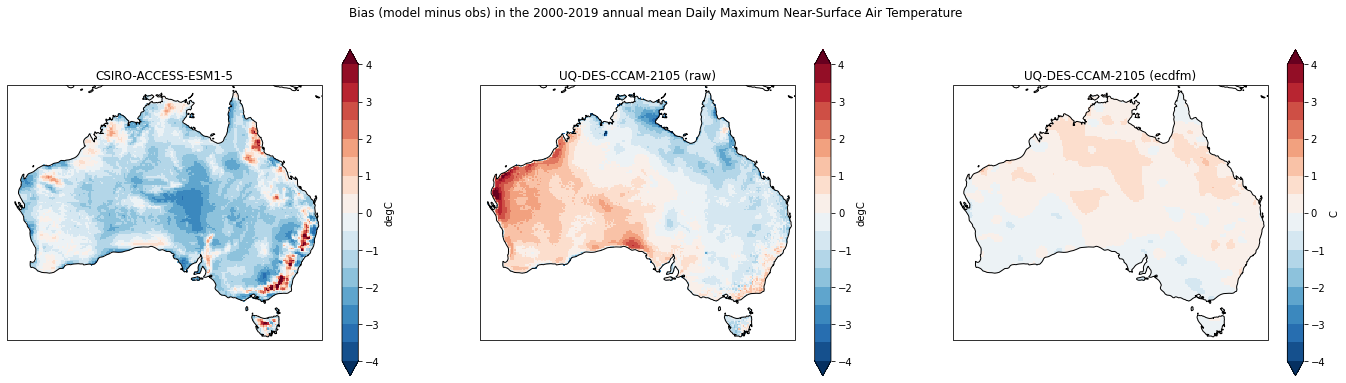

In [6]:
plot_comparison('tasmax', 'UQ-DES-CCAM-2105', 'RdBu_r', np.arange(-4, 4.01, 0.5))

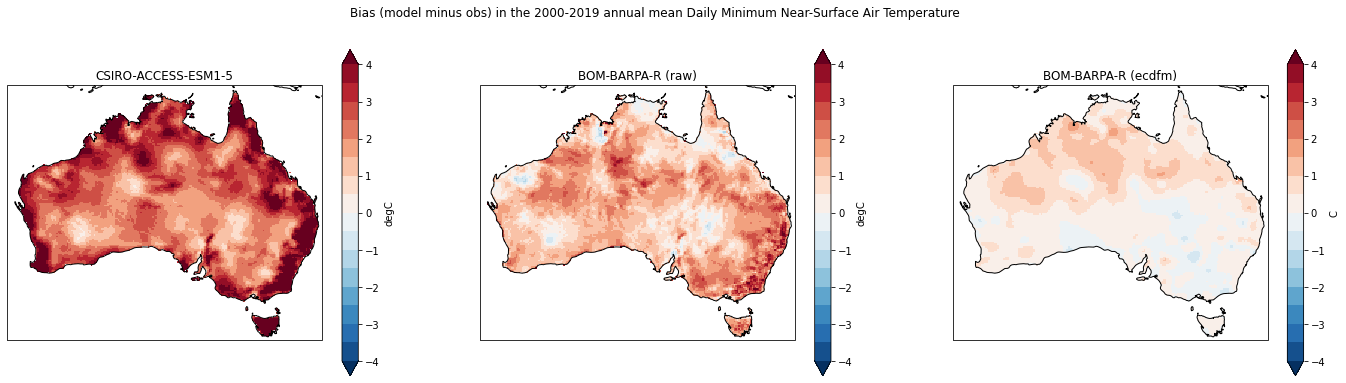

In [17]:
plot_comparison('tasmin', 'BOM-BARPA-R', 'RdBu_r', np.arange(-4, 4.01, 0.5))

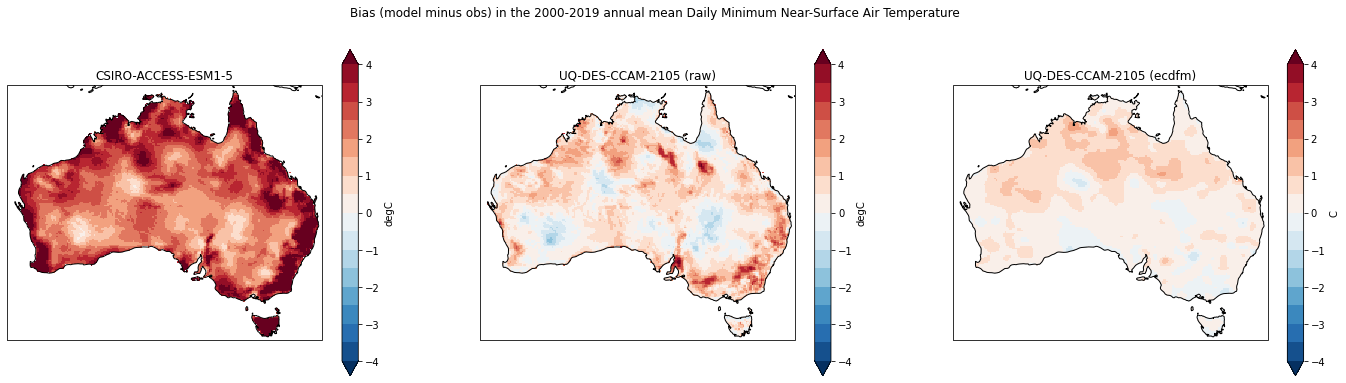

In [7]:
plot_comparison('tasmin', 'UQ-DES-CCAM-2105', 'RdBu_r', np.arange(-4, 4.01, 0.5))

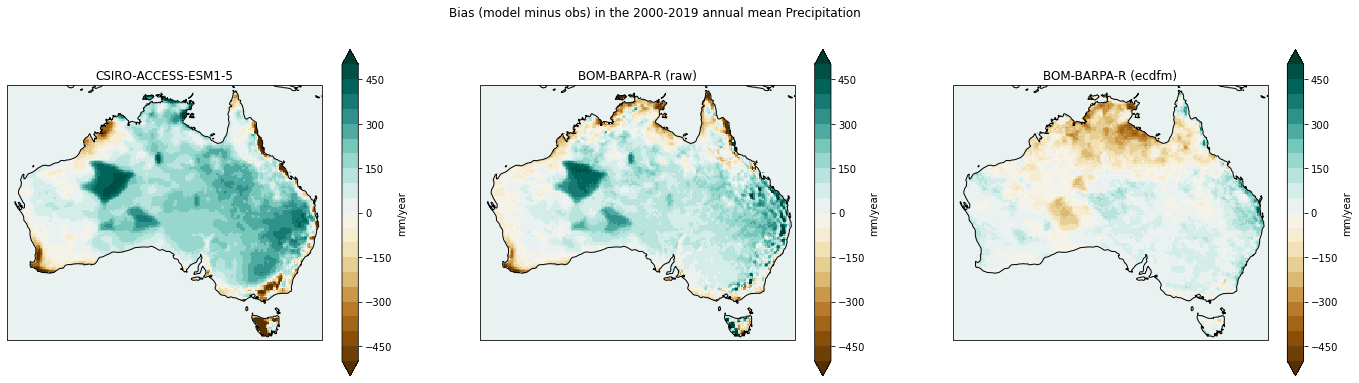

In [26]:
plot_comparison('pr', 'BOM-BARPA-R', 'BrBG', np.arange(-500, 500.1, 50))

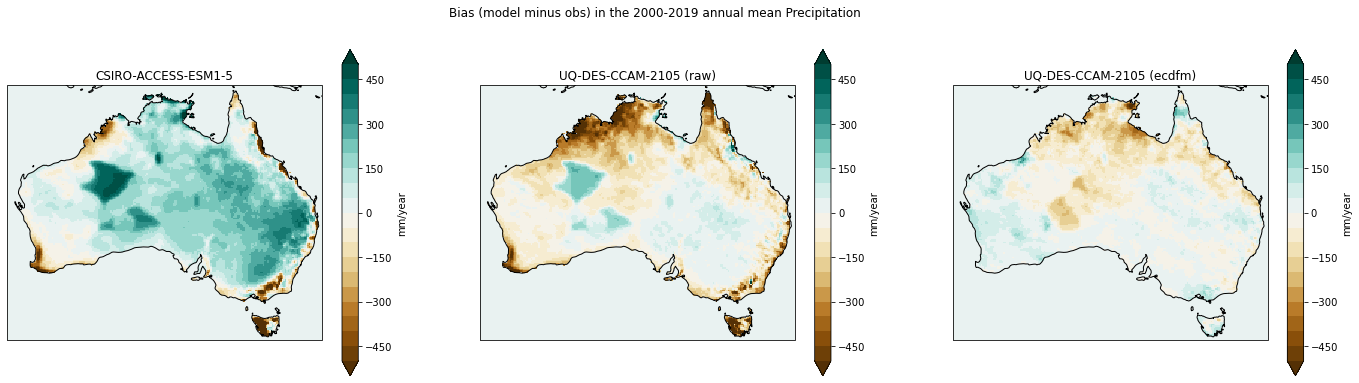

In [8]:
plot_comparison('pr', 'UQ-DES-CCAM-2105', 'BrBG', np.arange(-500, 500.1, 50))

TODO: Same plots but with ERA5 instead of ACCESS-ESM1-5 as the "GCM"